# Exploratory Data Analysis: TP53 Expression Matrices (Gambardella & Kinker)

This notebook performs EDA and prepares the data for multiclass classification of TP53 mutation status.

**Files:**
- `output/expression_matrix_with_tp53_status_gambardella.h5ad`
- `output/expression_matrix_with_tp53_status_kinker.h5ad`

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import mygene
import anndata as ad
import scanpy as sc

#Data Header Inspection and Gene Manipulation for Gambardella

In [13]:
# Load only the headers of the Gambardella and Kinker expression matrices from .h5ad files to inspect their structure


gambardella_path = '../output/expression_matrix_gambardella_with_tp53_status.h5ad'
kinker_path = '../output/expression_matrix_kinker_with_tp53_status.h5ad'

# Read AnnData objects (do not load X matrix to save memory)
gambardella_adata = ad.read_h5ad(gambardella_path, backed='r')
kinker_adata = ad.read_h5ad(kinker_path, backed='r')

# Get gene columns (var) and obs columns
gambardella_genes = list(gambardella_adata.var_names)
kinker_genes = list(kinker_adata.var_names)

gambardella_obs_cols = list(gambardella_adata.obs.columns)
kinker_obs_cols = list(kinker_adata.obs.columns)

print(f'Gambardella: {len(gambardella_genes)} gene columns, {len(gambardella_obs_cols)} obs columns')
print(f'Kinker: {len(kinker_genes)} gene columns, {len(kinker_obs_cols)} obs columns')

# Show first 5 gene columns for each
print('Gambardella first 5 gene columns:', gambardella_genes[:5])
print('Kinker first 5 gene columns:', kinker_genes[:5])

# Show last 5 gene columns for each
print('Gambardella last 5 gene columns:', gambardella_genes[-5:])
print('Kinker last 5 gene columns:', kinker_genes[-5:])

# Show obs columns for each
print('Gambardella obs columns:', gambardella_obs_cols)
print('Kinker obs columns:', kinker_obs_cols)

# Close backed AnnData objects
gambardella_adata.file.close()
kinker_adata.file.close()

Gambardella: 47096 gene columns, 2 obs columns
Kinker: 30313 gene columns, 2 obs columns
Gambardella first 5 gene columns: ['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', 'ENSG00000001036']
Kinker first 5 gene columns: ['A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1']
Gambardella last 5 gene columns: ['ENSG00000279270', 'ENSG00000280920', 'ENSG00000283420', 'ENSG00000284003', 'ENSG00000284685']
Kinker last 5 gene columns: ['SPATA13', 'TBC1D26', 'TIMM10B', 'TMBIM4', 'TMEM256-PLSCR3']
Gambardella obs columns: ['Cell_line', 'TP53_status']
Kinker obs columns: ['Cell_line', 'TP53_status']


In [14]:
# Map Ensembl gene IDs in Gambardella and Kinker AnnData var_names to gene symbols using mygene, and create mappings

mg = mygene.MyGeneInfo()

# For Gambardella: Replace var_names with gene symbols in the AnnData object (in memory)
gambardella_adata = ad.read_h5ad(gambardella_path)
gambardella_genes = list(gambardella_adata.var_names)
gambardella_ensembl_ids = [gene for gene in gambardella_genes if gene.startswith('ENSG')]
gambardella_query = mg.querymany(gambardella_ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
gambardella_id_to_symbol = {item['query']: item.get('symbol', None) for item in gambardella_query if 'symbol' in item}
# Replace Ensembl IDs with gene symbols where possible, otherwise keep the original ID
new_var_names = [gambardella_id_to_symbol.get(gene, gene) for gene in gambardella_genes]
gambardella_adata.var_names = new_var_names


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
22 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000280018', 2), ('E
930 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205485', 'ENS


In [15]:
# Check if previous cell (gene symbol mapping) went well by verifying AnnData var_names were updated
expected_type = str
if not all(isinstance(gene, expected_type) for gene in gambardella_adata.var_names):
    raise ValueError("Not all Gambardella var_names are strings after mapping. Previous cell may have failed.")

# Optionally, check for duplicates or missing values in var_names
if len(set(gambardella_adata.var_names)) != len(gambardella_adata.var_names):
    print("Warning: Duplicate gene symbols found in Gambardella var_names after mapping.")

# Get gene columns (var) and obs columns
gambardella_genes = list(gambardella_adata.var_names)
kinker_genes = list(kinker_adata.var_names)

gambardella_obs_cols = list(gambardella_adata.obs.columns)
kinker_obs_cols = list(kinker_adata.obs.columns)

print(f'Gambardella: {len(gambardella_genes)} gene columns, {len(gambardella_obs_cols)} obs columns')
print(f'Kinker: {len(kinker_genes)} gene columns, {len(kinker_obs_cols)} obs columns')

# Show first 5 gene columns for each
print('Gambardella first 5 gene columns:', gambardella_genes[:5])
print('Kinker first 5 gene columns:', kinker_genes[:5])

# Show last 5 gene columns for each
print('Gambardella last 5 gene columns:', gambardella_genes[-5:])
print('Kinker last 5 gene columns:', kinker_genes[-5:])

# Show obs columns for each
print('Gambardella obs columns:', gambardella_obs_cols)
print('Kinker obs columns:', kinker_obs_cols)

# Close backed AnnData objects
gambardella_adata.file.close()
kinker_adata.file.close()

Gambardella: 47096 gene columns, 2 obs columns
Kinker: 30313 gene columns, 2 obs columns
Gambardella first 5 gene columns: ['TSPAN6', 'DPM1', 'SCYL3', 'FIRRM', 'FUCA2']
Kinker first 5 gene columns: ['A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1']
Gambardella last 5 gene columns: ['OR52R1', 'ENSG00000280920', 'MIR4278', 'ENSG00000284003', 'ENSG00000284685']
Kinker last 5 gene columns: ['SPATA13', 'TBC1D26', 'TIMM10B', 'TMBIM4', 'TMEM256-PLSCR3']
Gambardella obs columns: ['Cell_line', 'TP53_status']
Kinker obs columns: ['Cell_line', 'TP53_status']


In [ ]:
# Salva il nuovo oggetto AnnData di Gambardella con i gene symbol come var_names
import os

output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)  # Assicurati che la cartella esista

output_path = os.path.join(output_dir, "expression_matrix_gambardella_with_tp53_status_and_gene_symbols.h5ad")
gambardella_adata.write(output_path)
#print(f"Nuovo file Gambardella creato e salvato con gene symbols come var_names in '{output_path}'")


# Merging two dataset

## Target Gene Inspection

In [7]:
# Load TP53 target genes and find their intersection with gene columns in Kinker and Gambardella datasets (using AnnData objects)

# Load TP53 target genes from Excel file
target_genes_df = pd.read_excel('../data/TP53target/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')

# Use the "Gene Symbol" column for target genes
target_genes = set(target_genes_df["Gene Symbol"].astype(str).str.upper())

# Get gene columns from AnnData objects (var_names)
kinker_genes = set([gene.upper() for gene in kinker_adata.var_names])
gambardella_genes = set([gene.upper() for gene in gambardella_adata.var_names])

# Find intersection with target genes
kinker_targets = target_genes & kinker_genes
gambardella_targets = target_genes & gambardella_genes

print(f"Number of TP53 target genes in Kinker: {len(kinker_targets)}")
print(f"Number of TP53 target genes in Gambardella: {len(gambardella_targets)}")
print(f"Example in Kinker: {list(kinker_targets)[:10]}")
print(f"Example in Gambardella: {list(gambardella_targets)[:10]}")

Number of TP53 target genes in Kinker: 338
Number of TP53 target genes in Gambardella: 337
Example in Kinker: ['DSP', 'ECT2', 'RBPJ', 'GDF15', 'DRAM1', 'AGT', 'MYOG', 'TSC2', 'APOB', 'TGM2']
Example in Gambardella: ['DSP', 'ECT2', 'RBPJ', 'GDF15', 'DRAM1', 'AGT', 'MYOG', 'TSC2', 'APOB', 'TGM2']


## Compare Columns (Genes/Features)

Let's see the overlap and differences between the two datasets' columns.

In [8]:
# Compare gene columns (var_names) between Gambardella and Kinker datasets to find shared and unique genes
gambardella_cols = set(gambardella_adata.obs.columns) | set(gambardella_adata.var_names)
kinker_cols = set(kinker_adata.obs.columns) | set(kinker_adata.var_names)

gene_cols_gambardella = set([gene.upper() for gene in gambardella_adata.var_names])
gene_cols_kinker = set([gene.upper() for gene in kinker_adata.var_names])

shared_genes = gene_cols_gambardella & gene_cols_kinker
unique_gambardella = gene_cols_gambardella - gene_cols_kinker
unique_kinker = gene_cols_kinker - gene_cols_gambardella

print(f'Shared genes: {len(shared_genes)}')
print(f'Unique to Gambardella: {len(unique_gambardella)}')
print(f'Unique to Kinker: {len(unique_kinker)}')

Shared genes: 18235
Unique to Gambardella: 28203
Unique to Kinker: 12078


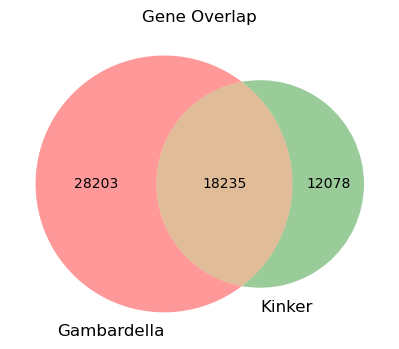

In [9]:
# Visualize the gene overlap
from matplotlib_venn import venn2
plt.figure(figsize=(6,4))
venn2([gene_cols_gambardella, gene_cols_kinker], set_labels=('Gambardella', 'Kinker'))
plt.title('Gene Overlap')
plt.show()

## Merge of the two dataset

In [23]:
#Common dataset
import anndata as ad

# Load the merged file
adata_merged = ad.read_h5ad("../output/merged_gambardella_kinker_common_genes.h5ad")

# Show general information
print(adata_merged)

# Show the final shape of the expression matrix (cells x genes)
print(f"Final shape of the expression matrix (cells x genes): {adata_merged.shape}")

# Show the first rows of the cell annotations
display(adata_merged.obs.head())

# Show the first rows of the gene annotations
display(adata_merged.var.head())

# Count the number of cells per dataset (check that both origins are present)
print(adata_merged.obs['dataset'].value_counts())

AnnData object with n_obs × n_vars = 64943 × 18235
    obs: 'Cell_line', 'TP53_status', 'dataset'
Final shape of the expression matrix (cells x genes): (64943, 18235)


,Cell_line,TP53_status,dataset
AU565_AAACCAGTTTGG,AU565,Missense_Mutation,gambardella
AU565_AAACGTGCAGCG,AU565,Missense_Mutation,gambardella
AU565_AAAGCCACATGC,AU565,Missense_Mutation,gambardella
AU565_AAAGTCGGCTGG,AU565,Missense_Mutation,gambardella
AU565_AAAGTGCCTAAA,AU565,Missense_Mutation,gambardella


""
TSPAN6
DPM1
SCYL3
FUCA2
GCLC


dataset
kinker         38364
gambardella    26579
Name: count, dtype: int64


# EDA

In [25]:
adata_merged = ad.read_h5ad("../output/merged_gambardella_kinker_common_genes.h5ad")

In [ ]:
#Sparsity
def check_sparsity(adata):
    """Print sparsity info for AnnData object."""
    print(f"Number of cells: {adata.shape[0]}")
    print(f"Number of genes: {adata.shape[1]}")
    print(f"Number of non-zero entries: {adata.X.nnz}")
    print(f"Sparsity: {1 - (adata.X.nnz / (adata.shape[0] * adata.shape[1])):.2%}")
check_sparsity(adata_merged)

Number of cells: 64943
Number of genes: 18235
Number of non-zero entries: 206649693
Sparsity: 82.55%


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


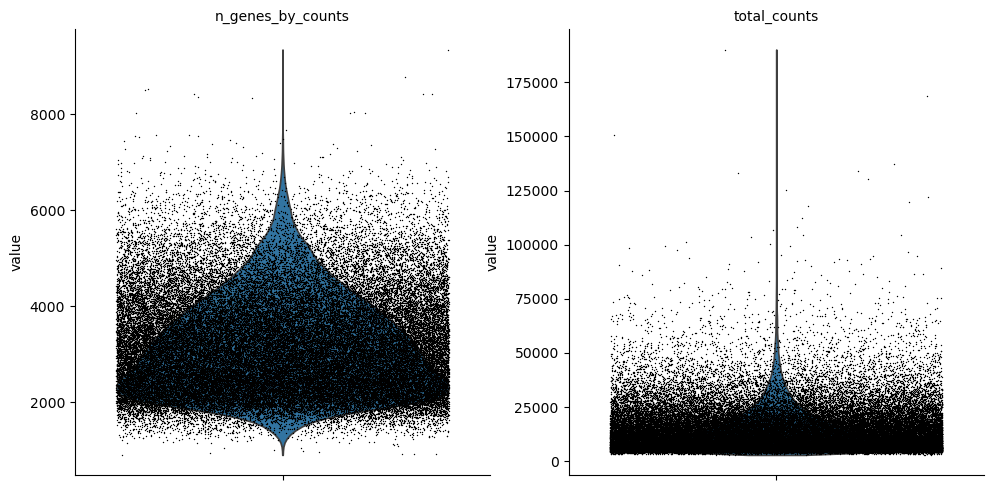

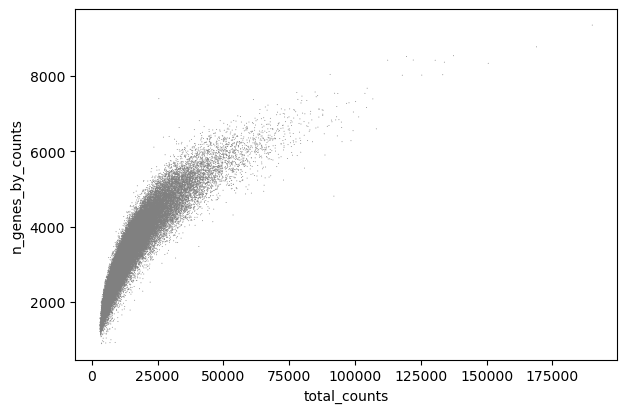

In [30]:
#Quality control
def show_qc_plots(adata, violin_cols=None, scatter_x=None, scatter_y=None):
    """Show QC plots for AnnData object."""
    sc.pp.calculate_qc_metrics(
    adata,inplace=True, log1p=True)
    sc.pl.violin(adata,violin_cols,jitter=0.4,multi_panel=True)
    sc.pl.scatter(adata, scatter_x, scatter_y)
show_qc_plots(adata_merged, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [ ]:
# #dublet detection     #COMPUTATIONALLY EXPENSIVE - doublets detected
sc.pp.scrublet(adata_merged)
print(f"Number of doublets detected: {adata_merged.obs['predicted_doublet'].sum()}")

Number of doublets detected: 0


In [35]:
#Feature selection
adata_merged.layers["pre_feature_selection"] = adata_merged.X.copy()


sc.pp.highly_variable_genes(adata_merged, min_mean=0.1, max_mean=3, min_disp=0.5 ) 
sc.pl.highly_variable_genes(adata_merged)
adata = adata_merged[:, adata_merged.var.highly_variable]

/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_data.py:144: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


ValueError: cannot specify integer `bins` when input data contains infinity